In [1]:
import pandas as pd
import numpy as np
from numpy import dstack
import logging
import itertools
import os
import gensim
import nltk
import re

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

import tensorflow as tf
from tensorflow import keras
from keras import utils
from keras.utils import to_categorical
from keras.models import Sequential, model_from_json, load_model
from keras.layers import Dense, Activation, Dropout, Input
from keras.layers.normalization import BatchNormalization
from keras.preprocessing import text, sequence

from nltk.corpus import stopwords



tf.test.gpu_device_name()

Using TensorFlow backend.


''

In [2]:
beauty = pd.read_csv("Beauty_shuffled.csv")
beauty.head()


,Unnamed: 0,itemid,title,Category,image_path
0,0,568397291,the body shop cushion,1,beauty_image/40b183d4becbd3e241f0eec1ee326aeb.jpg
1,1,692151107,coty airspun loose face powder,3,beauty_image/9e80d455fb90ea92bd093f42ff266010.jpg
2,2,1494939333,promo little baby collagen powder bedak origin...,3,beauty_image/ed83b4310de1087a49e20e3cc9b283f5.jpg
3,3,1668851817,giordani gold cc cream spf 35,5,beauty_image/39762bdfca9908741b402b9251727e16.jpg
4,4,1503851645,catrice the nude blossom collection eyeshadow ...,9,beauty_image/0699de63c71e8cab92b030574d4efd07.jpg


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 229266 samples, validate on 57317 samples
Epoch 1/20
229266/229266 [==============================] - 16s 69us/step - loss: 1.2318 - acc: 0.6358 - val_loss: 0.8638 - val_acc: 0.7386
Epoch 2/20
229266/229266 [==============================] - 16s 68us/step - loss: 0.8721 - acc: 0.7401 - val_loss: 0.8106 - val_acc: 0.7556
Epoch 3/20
229266/229266 [==============================] - 17s 75us/step - loss: 0.8214 - acc: 0.7525 - val_loss: 0.7915 - val_acc: 0.7587
Epoch 4/20
229266/229266 [==============================] - 17s 75us/step - loss: 0.7898 - acc: 0.7597 - val_loss: 0.7751 - val_acc: 0.7633
Epoch 5/20
229266/229266 [==============================] - 16s 69us/step - loss: 0.7687 - acc: 0.7644 - val_loss: 0.7657 - val_acc: 0.7672
Epoch 6/20
229

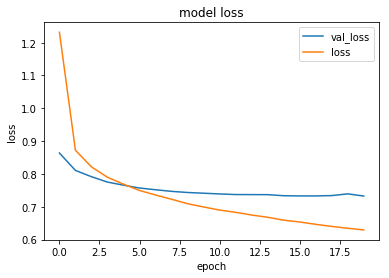

In [3]:
max_words = 1000
batch_size = 3000
epochs = 20



train_size = int(len(beauty) * 0.8) 
train_title = beauty['title'][:train_size] #Takes 70% of the training data to train
train_Category = beauty['Category'][:train_size] #Takes 70% of the training data to train

eval_title = beauty['title'][train_size:] #Takes remaining 30% of the training data to test
eval_Category = beauty['Category'][train_size:] #Takes remaining 30% of the training data to test

tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_title) # only fit on train

x_train = tokenize.texts_to_matrix(train_title)
x_eval = tokenize.texts_to_matrix(eval_title)

encoder = LabelEncoder()
encoder.fit(train_Category)
y_train = train_Category
y_eval = eval_Category
y_train = encoder.transform(train_Category)
y_eval = encoder.transform(eval_Category)

num_classes = np.max(y_train) - np.min(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)   # one hot encode the class values
y_eval = utils.to_categorical(y_eval, num_classes)



# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adagrad',
              metrics=['accuracy'])
              
history = model.fit(x_train, y_train,
                    validation_data=[x_eval, y_eval],
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

def display_training_graph(history):
    # summarize history for loss
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['val_loss', 'loss'], loc='upper right')
    plt.draw()


display_training_graph(history)

In [ ]:
score = model.evaluate(x_eval, y_eval,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

In [ ]:
filename = './Post_NDSC_beauty_model/' + 'model_' + str(1) + '.h5'
model.save(filename)
print('>Saved %s' % filename)